In [ ]:
import boto3, botocore ,sagemaker
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV


### find the bucket exist 

In [ ]:

sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()  # auto-managed bucket

print("Default bucket:", bucket)


### uploade the bucket 

In [ ]:


s3 = boto3.client("s3")
s3.upload_file("heart.csv", bucket, "data/heart.csv")

s3_path = f"s3://{bucket}/data/heart.csv"
print("Uploaded to:", s3_path)


### if data set exist no need to upload same , make exception

In [ ]:
s3 = boto3.client("s3")

bucket = "add bucket name"
key = "data/heart.csv"
local_file = "heart.csv"

try:
    s3.head_object(Bucket=bucket, Key=key)
    print(f"⚠️ File already exists in S3, skipping upload: s3://{bucket}/{key}")
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == "404":
        s3.upload_file(local_file, bucket, key)
        print(f"✅ Uploaded to: s3://{bucket}/{key}")
    else:
        raise

### import datadrame from s3

In [ ]:
import pandas as pd

bucket = "add bucket name"
key = "data/heart.csv"
s3_path = f"s3://{bucket}/{key}"

df = pd.read_csv(s3_path)
print(df.head())


## EDA

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
70,54,1,2,120,258,0,0,147,0,0.4,1,0,3,1
141,43,1,0,115,303,0,1,181,0,1.2,1,0,2,1
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
213,61,0,0,145,307,0,0,146,1,1.0,1,0,3,0
111,57,1,2,150,126,1,1,173,0,0.2,2,1,3,1


,count,mean,std,min,25%,50%,75%,max
age,303.0,54.366337,9.082101,29.0,47.5,55.0,61.0,77.0
sex,303.0,0.683168,0.466011,0.0,0.0,1.0,1.0,1.0
cp,303.0,0.966997,1.032052,0.0,0.0,1.0,2.0,3.0
trestbps,303.0,131.623762,17.538143,94.0,120.0,130.0,140.0,200.0
chol,303.0,246.264026,51.830751,126.0,211.0,240.0,274.5,564.0
fbs,303.0,0.148515,0.356198,0.0,0.0,0.0,0.0,1.0
restecg,303.0,0.528053,0.525860,0.0,0.0,1.0,1.0,2.0
thalach,303.0,149.646865,22.905161,71.0,133.5,153.0,166.0,202.0
exang,303.0,0.326733,0.469794,0.0,0.0,0.0,1.0,1.0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

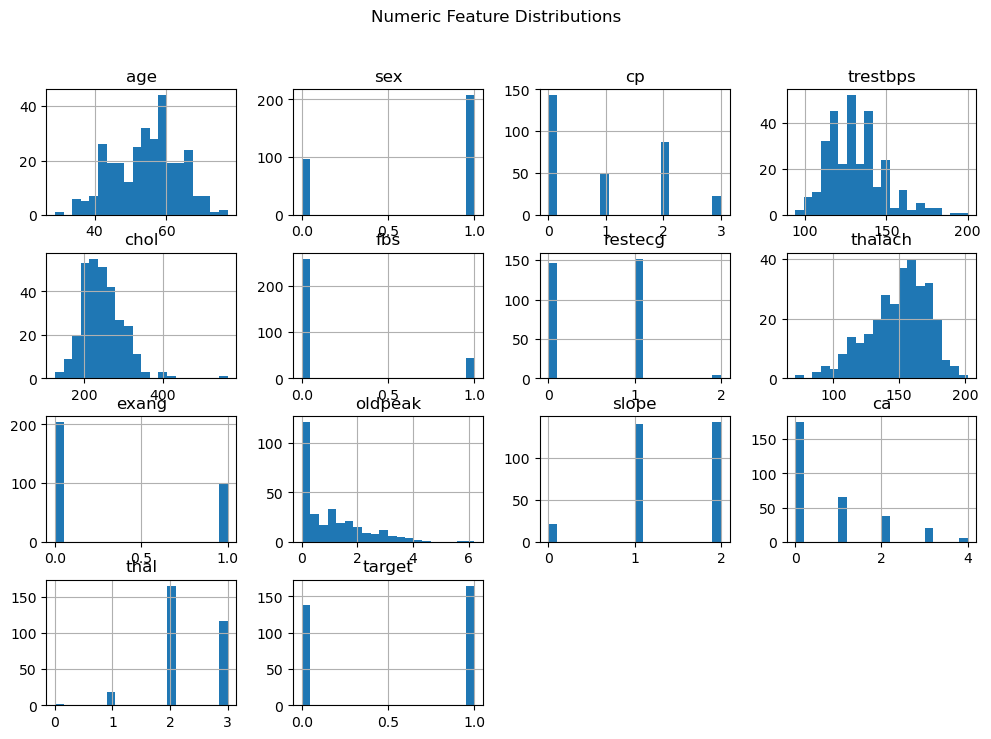

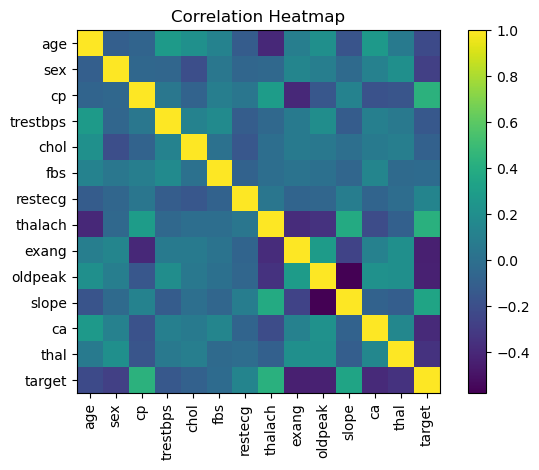

In [5]:

display(df.sample(min(5, len(df))))
display(df.describe(include='all').T)
df.info()

na_counts = df.isna().sum().sort_values(ascending=False)
display(na_counts.head(20))

# Optional: quick numeric distributions
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if numeric_cols:
    df[numeric_cols].hist(bins=20, figsize=(12, 8))
    plt.suptitle("Numeric Feature Distributions"); plt.show()

# Optional: correlation heatmap (if enough numeric columns)
if len(numeric_cols) > 1:
    corr = df[numeric_cols].corr(numeric_only=True)
    plt.imshow(corr, interpolation='nearest')
    plt.title("Correlation Heatmap")
    plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=90)
    plt.yticks(range(len(numeric_cols)), numeric_cols)
    plt.colorbar()
    plt.tight_layout()
    plt.show()


## make split and test train

In [6]:
from sklearn.model_selection import train_test_split
import os

# Features and target
X = df.drop("target", axis=1)   # assuming column 'target' is the label
y = df["target"]

# Cell 5: Train/Test Split
X = df.drop("target", axis=1)
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("✅ Train/Test split done")




✅ Train/Test split done


In [7]:
# Cell 6: Logistic Regression (baseline)
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print("🔎 Baseline Model Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


🔎 Baseline Model Performance:
Accuracy: 0.8688524590163934
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        29
           1       0.88      0.88      0.88        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



### fine tune 

In [8]:
# Cell 7: Hyperparameter Tuning with GridSearchCV
param_grid = {
    "C": [0.01, 0.1, 1, 10],
    "solver": ["liblinear", "lbfgs"]
}

grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=3, scoring="accuracy")
grid.fit(X_train, y_train)

print("✅ Best Parameters:", grid.best_params_)
print("✅ Best CV Score:", grid.best_score_)

# Evaluate best model
best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_test)

print("🔎 Tuned Model Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))


✅ Best Parameters: {'C': 1, 'solver': 'liblinear'}
✅ Best CV Score: 0.8059670781893004
🔎 Tuned Model Performance:
Accuracy: 0.8688524590163934
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        29
           1       0.88      0.88      0.88        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



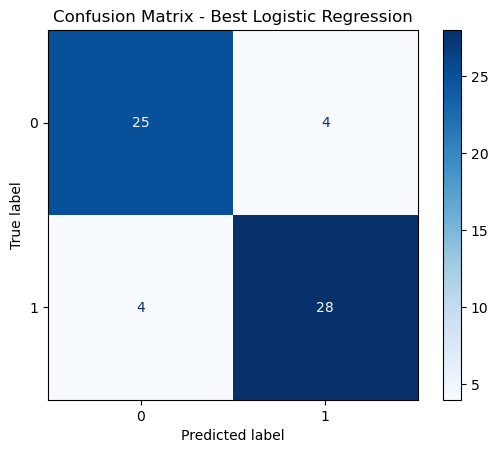

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, cmap="Blues")
plt.title("Confusion Matrix - Best Logistic Regression")
plt.show()


In [ ]:
import joblib
import boto3
import os

# Local save
model_path = "best_logistic_model.pkl"
joblib.dump(best_model, model_path)
print(f"💾 Model saved locally at {model_path}")

# Upload to S3
s3 = boto3.client("s3")
bucket_name = bucket
s3_key = "models/best_logistic_model.pkl"

s3.upload_file(model_path, bucket_name, s3_key)

print(f"📤 Model uploaded to s3://{bucket_name}/{s3_key}")
